# Introduction
<hr style="border:2px solid black"> </hr>


**What?** Regression with Neural Networks implemented in PyTorch and Keras



# Import modules
<hr style="border:2px solid black"> </hr>

In [1]:
# PyTorch modules
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
# Custom-made functions
from KPT.PyTorchTools import EarlyStopping
from torchinfo import summary

# Keras modules
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.layers import Dense

# Others
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from numpy.random import seed
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# What is the goal?
<hr style="border:2px solid black"> </hr>


- We're trying to build a common interface for both KERAS and PyTorch in order to build a MLP applied to regression problem given any function.
- **Why KERAS and not Tensor flow directly?** Keras is just a wrapper built around tensor flow and it is much easier to write a model.
- **nn.Model() vs. nn.Squential?** We have decided to use the `nn.Sequential()` just because the way you build the model is very similar to Keras.
- The code reported here serves as a starter to build a common interface.



# Getting a test function
<hr style="border:2px solid black"> </hr>


- Neural networks are sometimes described as a **universal function approximator**. 
- In this notebook we'll use a complex enough function and we'll build an MPL network using Keras and PyTorch
- After a common interface for Keras and Pytorch is build we can feed any function to this common interface and see how Keras and pPyTorch differ.



In [2]:
x = np.linspace(0, 10, 500)
y = np.sin(x)
yNoise = np.sin(x) + np.random.normal(0, 0.1, len(x))

<ipython-input-3-a689fb3fcac3>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


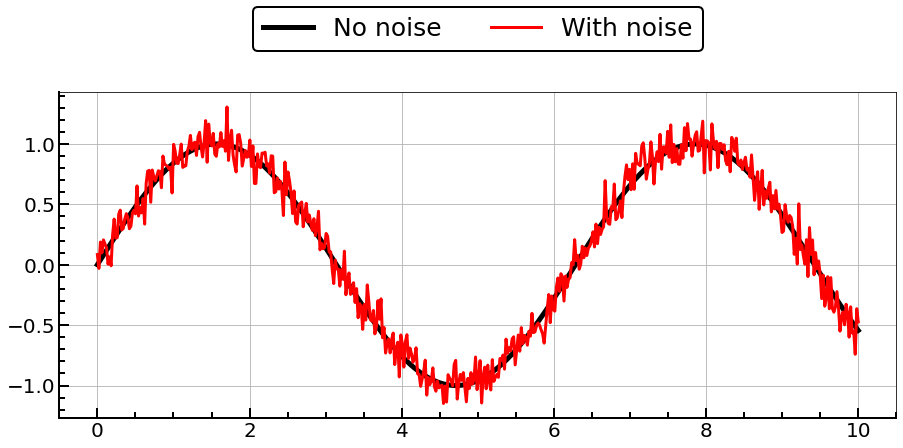

In [3]:
rcParams['font.size'] = 20
rcParams['figure.figsize'] = 15, 6

fig = plt.figure() 
ax = fig.add_subplot(111) 

plt.plot(x, y, "k-", lw = 5, label = "No noise")
plt.plot(x, yNoise, "r-", lw = 3, label = "With noise")
#plt.plot(xx, yy, "m-", lw = 3)

ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.grid()
ax.minorticks_on()

legendObject = ax.legend(loc = 'upper center', bbox_to_anchor=(0.5, 1.3),
          ncol = 2, fontsize = 25, fancybox = True, shadow = False,
          facecolor = "w", framealpha = 1)
legendObject.get_frame().set_linewidth(2.0)
legendObject.get_frame().set_edgecolor("k")

fig.show()

# Splitting the dataset
<hr style="border:2px solid black"> </hr>


- Good practice: set = train + test + validation
- In practice (not so good practice): set = train + test
- The question is: **while using early stopping, shall I use test or validation method?** If we are using early stopping as a training termination criterion then it becomes part of your learning algorithm, meaning the model is implicitly seen these data. Thus this data cannot be used for testing otherwise you are leaking info when you are not supposed to.

    
- While practicing you'll see that is difficult to see this leakage and people simply do not bother with it.
- There are cases where you **simply cannot have** all three sets and then you have to rely on other validation methods such as a cross validation etc.



In [4]:
X_test, X_, y_test, y_ = train_test_split(x, yNoise,
                                                    test_size = 0.8, 
                                                    random_state = 7, 
                                                    shuffle = True)

X_valid, X_train, y_valid, y_train = train_test_split(X_, y_,
                                                    test_size = 0.8, 
                                                    random_state = 7, 
                                                    shuffle = True)

print("Checking TRAIN set dimensions: ", len(X_train), len(y_train))
print("Checking VALIDATION set dimensions: ", len(X_valid), len(y_valid))
print("Checking TEST set dimensions: ", len(X_test), len(y_test))
print("Checking ORIGINAL dimensions: ", len(x), len(y))

Checking TRAIN set dimensions:  320 320
Checking VALIDATION set dimensions:  80 80
Checking TEST set dimensions:  100 100
Checking ORIGINAL dimensions:  500 500


In [5]:
Set = {}
Set["X_test"]  = X_test
Set["X_train"] = X_
Set.keys()       

dict_keys(['X_test', 'X_train'])

In [6]:
len(Set["X_test"])

100

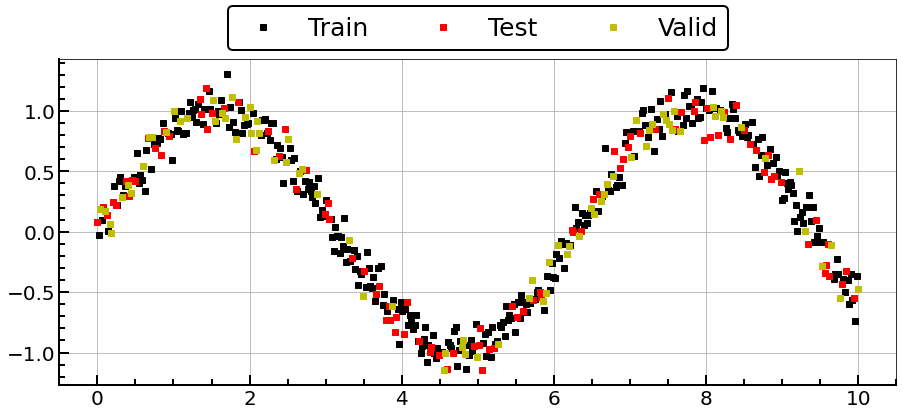

In [7]:
rcParams['font.size'] = 20
rcParams['figure.figsize'] = 15, 6

fig = plt.figure() 
ax = fig.add_subplot(111) 

plt.plot(X_train, y_train, "ks", lw = 5, label = "Train")
plt.plot(X_test, y_test, "rs", lw = 3, label = "Test")
plt.plot(X_valid, y_valid, "ys", lw = 3, label = "Valid")

ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.grid()
ax.minorticks_on()

legendObject = ax.legend(loc = 'upper center', bbox_to_anchor=(0.5, 1.2),
          ncol = 3, fontsize = 25, fancybox = True, shadow = False,
          facecolor = "w", framealpha = 1)
legendObject.get_frame().set_linewidth(2.0)
legendObject.get_frame().set_edgecolor("k")

plt.show();

# Input preparation
<hr style="border:2px solid black"> </hr>


- In this section we're preparing the data to be ingested by the two frameworks.
- **Keras** (`_K`) accepts `numpy.ndarray`
- **PyTorch** (`_PT`) is a bit more picky and you have to use `Variable()` which returns a tensor. Make sure you pass a 2D numpy.ndarray to `Variable`, you can do this by using `reshape()`



## PyTorch


- `num_workers` really affects the running time on CPU. 
- See references for a disucssion about it.



In [8]:
def createPTdataLoader(X,y):
    """Create PyTorch data loader
    
    X np.ndarray
        Feature vector/matrix
    y np.ndarray
        target(s)
    """
    
    # From numpy to torch tensor
    x = torch.from_numpy(X)
    y = torch.from_numpy(y)
    print(x.shape, y.shape)

    # 2D dimensinal input
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    print(x.shape, y.shape)

    # PyTorch can only train on Variable
    x, y = Variable(x.float()), Variable(y.float())
    print(x.shape, y.shape)
    print(type(x), type(y))

    torch_dataset = Data.TensorDataset(x, y)

    # Split data in batches
    loader = Data.DataLoader(
        dataset = torch_dataset, 
        batch_size = 64, 
        shuffle = True, 
        num_workers = 2)
    
    return loader, x, y

In [9]:
loader_train, xPT_train, yPT_train = createPTdataLoader(X_train, y_train)
loader_valid, xPT_valid, yPT_valid = createPTdataLoader(X_valid, y_valid)
loader_test, xPT_test, yPT_test = createPTdataLoader(X_test, y_test)

torch.Size([320]) torch.Size([320])
torch.Size([320, 1]) torch.Size([320, 1])
torch.Size([320, 1]) torch.Size([320, 1])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([80]) torch.Size([80])
torch.Size([80, 1]) torch.Size([80, 1])
torch.Size([80, 1]) torch.Size([80, 1])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([100]) torch.Size([100])
torch.Size([100, 1]) torch.Size([100, 1])
torch.Size([100, 1]) torch.Size([100, 1])
<class 'torch.Tensor'> <class 'torch.Tensor'>


## Keras

In [10]:
# Keras would work even if you do not use reshape(), but for consistency we're using it anyway
xK_train = X_train.reshape(-1,1)
yK_train = y_train.reshape(-1,1)

xK_valid = X_valid.reshape(-1,1)
yK_valid = y_valid.reshape(-1,1)

xK_test = X_test.reshape(-1,1)
yK_test = y_test.reshape(-1,1)

print("Check _train shape", xK_train.shape, yK_train.shape)
print("Check _train type", type(xK_train), type(yK_train))
print("Check _valid shape", xK_valid.shape, yK_valid.shape)
print("Check _valid type", type(xK_valid), type(yK_valid))
print("Check _test shape", xK_test.shape, yK_test.shape)
print("Check _test type", type(xK_test), type(yK_test))

Check _train shape (320, 1) (320, 1)
Check _train type <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Check _valid shape (80, 1) (80, 1)
Check _valid type <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Check _test shape (100, 1) (100, 1)
Check _test type <class 'numpy.ndarray'> <class 'numpy.ndarray'>


# Model architecture
<hr style="border:2px solid black"> </hr>


- This is where the MLP architecture get defined for both framework.

- It is evident the similarity btw the two frameworks and the phylosophy behind the `Sequential` module.

- This module allows you to build the model in a loop and in automated manner. The second requirement was **paramount** for this project.

- However, there are a couple of differences btw the two framework:
    - The equivalent of the Keras `Dense` is the PyTorch `Linear`.
    - PyTorch uses **dynamic model definition**, it cannot infer the output sizes of the previous layers.
    - In Keras, you need to provide `input_length` on the first layer. 
    


## PyTorch


**Method No1**<br>
`
model_PT = torch.nn.Sequential(
        torch.nn.Linear(1, 200),
        torch.nn.ReLU(),
        torch.nn.Linear(200, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 1),
)
`

**Method No2**<br>
`
layers = []
layers.append(torch.nn.Linear(1, 200))
layers.append(torch.nn.ReLU())
layers.append(torch.nn.Linear(200, 100))
layers.append(torch.nn.ReLU())
layers.append(torch.nn.Linear(100, 100))
layers.append(torch.nn.ReLU())
layers.append(torch.nn.Linear(100, 1))
model_PT = nn.Sequential(*layers)
`

- Method #1 is totally equivalent to Method #2
- We are going to use the second method as it allows to build it in a loop.



In [11]:
torch.manual_seed(1)

layers = []
layers.append(torch.nn.Linear(1, 200))
layers.append(torch.nn.ReLU())
layers.append(torch.nn.Linear(200, 100))
layers.append(torch.nn.ReLU())
layers.append(torch.nn.Linear(100, 100))
layers.append(torch.nn.ReLU())
layers.append(torch.nn.Linear(100, 1))

model_PT = nn.Sequential(*layers)

optimizer = torch.optim.Adam(model_PT.parameters(), lr = 0.005)
# MSE is the mean squared loss
loss_func = torch.nn.MSELoss()

early_stopping_PT = EarlyStopping(patience = 50, delta = 0.001)

In [12]:
model_PT.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=1, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=1, bias=True)
)>

In [13]:
model_PT.state_dict

<bound method Module.state_dict of Sequential(
  (0): Linear(in_features=1, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=1, bias=True)
)>

In [14]:
print(model_PT)

Sequential(
  (0): Linear(in_features=1, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=1, bias=True)
)



- Torchinfo provides information complementary to what is provided by `print(your_model)` in PyTorch, similar to Tensorflow's `model.summary()`.

- Unlike Keras, PyTorch has a **dynamic computational graph** which can adapt to any compatible input shape across multiple calls e.g. any sufficiently large image size (for a fully convolutional network).

- As such, it cannot present an inherent set of input/output shapes for each layer, as these are input-dependent, and why in the above package you must specify the input dimensions.



In [15]:
from torchinfo import summary
summary(model_PT, input_size = (200, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Linear: 1-1                            [200, 200]                400
├─ReLU: 1-2                              [200, 200]                --
├─Linear: 1-3                            [200, 100]                20,100
├─ReLU: 1-4                              [200, 100]                --
├─Linear: 1-5                            [200, 100]                10,100
├─ReLU: 1-6                              [200, 100]                --
├─Linear: 1-7                            [200, 1]                  101
Total params: 30,701
Trainable params: 30,701
Non-trainable params: 0
Total mult-adds (M): 6.14
Input size (MB): 0.00
Forward/backward pass size (MB): 0.64
Params size (MB): 0.12
Estimated Total Size (MB): 0.77

In [16]:
dir(model_PT)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_item_by_idx',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_version',
 'add_module',
 'appl

## Keras


**Method No1**

`model_K = keras.Sequential([
    layers.Dense(200, activation = 'relu', input_shape = [1]),
    layers.Dense(100, activation = 'relu'),
    layers.Dense(100, activation = 'relu'),
    layers.Dense(1),
])`




In [17]:
seed(1)

model_K = keras.Sequential()
model_K.add(Dense(200, activation='relu', input_dim=1))
model_K.add(Dense(100, activation='relu'))
model_K.add(Dense(100, activation='relu'))
model_K.add(Dense(1))


model_K.compile(
    optimizer='adam',
    loss='mae',
)
early_stopping_K = callbacks.EarlyStopping(
    # Minimium amount of change to count as an improvement
    min_delta=0.001,
    # How many epochs to wait before stopping.
    # Meaning, when there is no improvement for more than 50 epoches, the program stop
    patience=50,
    restore_best_weights=True,
)

In [18]:
# If you want to knw about what get fed into each layer
model_K.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'batch_input_shape': (None, 1),
    'dtype': 'float32',
    'units': 200,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'dtype': 'float32',
    'units': 100,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initia


- `None` is the batch dimension.



In [19]:
model_K.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 30,701
Trainable params: 30,701
Non-trainable params: 0
_________________________________________________________________


In [20]:
dir(model_K)

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_graph_network_for_inferred_shape',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_cast_single_input',
 '_check_call_args',
 '_checkpoint_dependencies',
 '_clear_los

# Comparison of the two equivalent architectures
<hr style="border:2px solid black"> </hr>


- In this section we'll build again the model using different name.
- The idea is to compare side-by-side how the model are different in the way the build the same architecture.
- We have 4 layers in total where two are hidden layers and the other two are essentially the input and output.



In [21]:
# Keras architecture
model_Keras = keras.Sequential()
model_Keras.add(Dense(200, activation='relu',
                      input_dim=1))
model_Keras.add(Dense(100, activation='relu'))
model_Keras.add(Dense(100, activation='relu'))
model_Keras.add(Dense(1))

model_Keras.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               400       
_________________________________________________________________
dense_5 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 30,701
Trainable params: 30,701
Non-trainable params: 0
_________________________________________________________________


In [22]:
# PyTorch architecture
layers = []
layers.append(torch.nn.Linear(1, 200))
layers.append(torch.nn.ReLU())
layers.append(torch.nn.Linear(200, 100))
layers.append(torch.nn.ReLU())
layers.append(torch.nn.Linear(100, 100))
layers.append(torch.nn.ReLU())
layers.append(torch.nn.Linear(100, 1))

model_PyTorch = nn.Sequential(*layers)

#summary(model_PyTorch, input_size=(200, 1))
summary(model_PyTorch)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            400
├─ReLU: 1-2                              --
├─Linear: 1-3                            20,100
├─ReLU: 1-4                              --
├─Linear: 1-5                            10,100
├─ReLU: 1-6                              --
├─Linear: 1-7                            101
Total params: 30,701
Trainable params: 30,701
Non-trainable params: 0

# Training
<hr style="border:2px solid black"> </hr>


- **Keras** seems to abstract much more the training process than does **PyTorch**.



## PyTorch

In [23]:
train_lossHistory_PT = []
valid_lossHistory_PT = []
train_losses = []
valid_losses = []

# Start training
for epoch in range(200):

    # ----Training loop----
    # model_PT.train()
    for step, (batch_x, batch_y) in enumerate(loader_train):

        b_x = Variable(batch_x)
        b_y = Variable(batch_y)

        # Input x and predict based on x
        prediction = model_PT(b_x)
        # Must be (1. nn output, 2. target)
        loss = loss_func(prediction, b_y)

        # Clear gradients for next train
        optimizer.zero_grad()
        # Backpropagation, compute gradients
        loss.backward()
        # Apply gradients
        optimizer.step()
        # Record training loss
        currentBatchLoss = loss.item()
        train_losses.append(currentBatchLoss)

    # ----Validation loop----
    # model_PT.eval()
    for batch_x, batch_y in loader_valid:

        b_x = Variable(batch_x)
        b_y = Variable(batch_y)

        # Input x and predict based on x
        prediction = model_PT(b_x)
        # Must be (1. nn output, 2. target)
        loss = loss_func(prediction, b_y)

        # Record training loss
        currentBatchLoss = loss.item()
        valid_losses.append(currentBatchLoss)

    train_loss_avr = np.average(train_losses)
    train_lossHistory_PT.append(train_loss_avr)

    valid_loss_avr = np.average(valid_losses)
    valid_lossHistory_PT.append(valid_loss_avr)
    print("Current #", epoch, " loss", train_loss_avr,
          " valid_loss", valid_loss_avr)

    # clear lists to track next epoch
    train_losses = []
    valid_losses = []

    # early_stopping needs the validation loss to check if it has decresed,
    # and if it has, it will make a checkpoint of the current model
    # initialize the early_stopping object
    early_stopping_PT(valid_loss_avr, model_PT)

    if early_stopping_PT.early_stop:
        print("Early stopping")
        break

Current # 0  loss 0.8343709290027619  valid_loss 0.47155265510082245
Current # 1  loss 0.46350101232528684  valid_loss 0.38746868073940277
Current # 2  loss 0.4196547269821167  valid_loss 0.3557296395301819
Current # 3  loss 0.4169956803321838  valid_loss 0.3573260009288788
EarlyStopping counter: 1 out of 50
Current # 4  loss 0.3817540526390076  valid_loss 0.32235875725746155
Current # 5  loss 0.3666978359222412  valid_loss 0.34173421561717987
EarlyStopping counter: 1 out of 50
Current # 6  loss 0.3439637362957001  valid_loss 0.3423983156681061
EarlyStopping counter: 2 out of 50
Current # 7  loss 0.32902969121932985  valid_loss 0.3194708675146103
Current # 8  loss 0.3533299624919891  valid_loss 0.2921496331691742
Current # 9  loss 0.31402506232261657  valid_loss 0.25198589265346527
Current # 10  loss 0.2816885083913803  valid_loss 0.17665575444698334
Current # 11  loss 0.257101845741272  valid_loss 0.22895120829343796
EarlyStopping counter: 1 out of 50
Current # 12  loss 0.224811956286

Current # 85  loss 0.014479031413793563  valid_loss 0.014029101934283972
EarlyStopping counter: 9 out of 50
Current # 86  loss 0.014472628198564052  valid_loss 0.010618145344778895
EarlyStopping counter: 10 out of 50
Current # 87  loss 0.014949691854417324  valid_loss 0.015718091279268265
EarlyStopping counter: 11 out of 50
Current # 88  loss 0.014977523125708103  valid_loss 0.014735219534486532
EarlyStopping counter: 12 out of 50
Current # 89  loss 0.017427666671574117  valid_loss 0.01693566655740142
EarlyStopping counter: 13 out of 50
Current # 90  loss 0.019991062581539154  valid_loss 0.023244095966219902
EarlyStopping counter: 14 out of 50
Current # 91  loss 0.01889685932546854  valid_loss 0.016383103094995022
EarlyStopping counter: 15 out of 50
Current # 92  loss 0.015431537106633187  valid_loss 0.013295914977788925
EarlyStopping counter: 16 out of 50
Current # 93  loss 0.015734422765672208  valid_loss 0.013910248409956694
EarlyStopping counter: 17 out of 50
Current # 94  loss 0.0

## Keras

In [24]:
history_K = model_K.fit(
    xK_train, yK_train,
    validation_data = (xK_valid, yK_valid),
    batch_size = 64,
    epochs = 200,
    callbacks = [early_stopping_K],
    verbose = 1,  
)

Epoch 1/200
5/5 [==============================] - 1s 37ms/step - loss: 0.6518 - val_loss: 0.5876
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.6085 - val_loss: 0.6194
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.6110 - val_loss: 0.5802
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.6037 - val_loss: 0.5890
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.6026 - val_loss: 0.5994
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.5925 - val_loss: 0.5636
Epoch 7/200
5/5 [==============================] - 0s 6ms/step - loss: 0.6063 - val_loss: 0.5660
Epoch 8/200
5/5 [==============================] - 0s 7ms/step - loss: 0.5969 - val_loss: 0.5804
Epoch 9/200
5/5 [==============================] - 0s 7ms/step - loss: 0.5960 - val_loss: 0.5498
Epoch 10/200
5/5 [==============================] - 0s 6ms/step - loss: 0.5864 - val_loss: 0.5531
Epoch 11/200
5/5 [==========

5/5 [==============================] - 0s 6ms/step - loss: 0.1225 - val_loss: 0.1260
Epoch 168/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1176 - val_loss: 0.1024
Epoch 169/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0993 - val_loss: 0.0853
Epoch 170/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0907 - val_loss: 0.1114
Epoch 171/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1058 - val_loss: 0.1150
Epoch 172/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1351 - val_loss: 0.1062
Epoch 173/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1047 - val_loss: 0.0962
Epoch 174/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0981 - val_loss: 0.0859
Epoch 175/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0903 - val_loss: 0.0872
Epoch 176/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0880 - val_loss: 0.0928
Epoch 177/200
5/5 [=====

# Model diagnostic
<hr style="border:2px solid black"> </hr>


- In here we are checking two things:
    - Metrics on the test set and
    - Learning curves



## Performance on the test set

In [25]:
def getMetrics(model, xSet, ySet, setName):
    """Get metrics

    Applied to regression problmes
    """

    if "keras" in setName.lower().split("_"):
        preds = model.predict(xSet)
    else:
        preds = model(xSet).data.numpy()

    r2s = r2_score(ySet, preds)
    mse = mean_squared_error(ySet, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(ySet, preds)

    print("[MSE]_"+str(setName)+": %.4f" % mse)
    print("[RMSE]_"+str(setName)+": %.4f" % rmse)
    print("[MAE]_"+str(setName)+": %.4f" % mae)
    print("[R2]_"+str(setName)+": %.4f" % r2s)
    print("*****************")

In [26]:
getMetrics(model_K, xK_test, yK_test, "TEST_KERAS")
getMetrics(model_PT, xPT_test, yPT_test, "TEST_PT")

[MSE]_TEST_KERAS: 0.0202
[RMSE]_TEST_KERAS: 0.1422
[MAE]_TEST_KERAS: 0.1206
[R2]_TEST_KERAS: 0.9579
*****************
[MSE]_TEST_PT: 0.0138
[RMSE]_TEST_PT: 0.1176
[MAE]_TEST_PT: 0.0897
[R2]_TEST_PT: 0.9712
*****************


## Learning curves

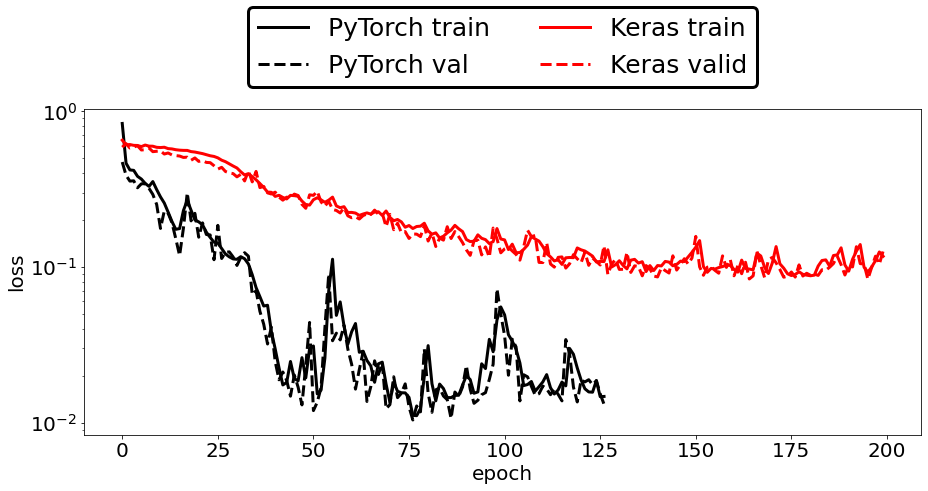

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(range(len(train_lossHistory_PT)), train_lossHistory_PT,
         "k-", lw=3, label="PyTorch train")
plt.plot(range(len(valid_lossHistory_PT)),
         valid_lossHistory_PT, "k--", lw=3, label="PyTorch val")

plt.plot(history_K.history["loss"], "r-",  lw=3, label="Keras train")
plt.plot(history_K.history["val_loss"], "r--",  lw=3, label="Keras valid")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.yscale('log')


# How to control it in a loop (more elegant)
legendObject = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
                         ncol=2, fontsize=25, fancybox=True, shadow=False,
                         facecolor="w", framealpha=1)
legendObject.get_frame().set_linewidth(3.0)
legendObject.get_frame().set_edgecolor("k")

for i in range(len(legendObject.legendHandles)):
    legendObject.legendHandles[i]._sizes = [80]

plt.show()

plt.show()
fig.savefig("./img/learningCurves.png", bbox_inches='tight')

# Comparisons
<hr style="border:2px solid black"> </hr>


- One of the interesting things to notice is how both frameworks have learnt the true function and not the function + noise.
- Keep in mind that have trained, validated and tested the data on the noisy dataset.
- The denoised trend is plotted in the figure below to show how the frameworks have learnt to ignore the noise.



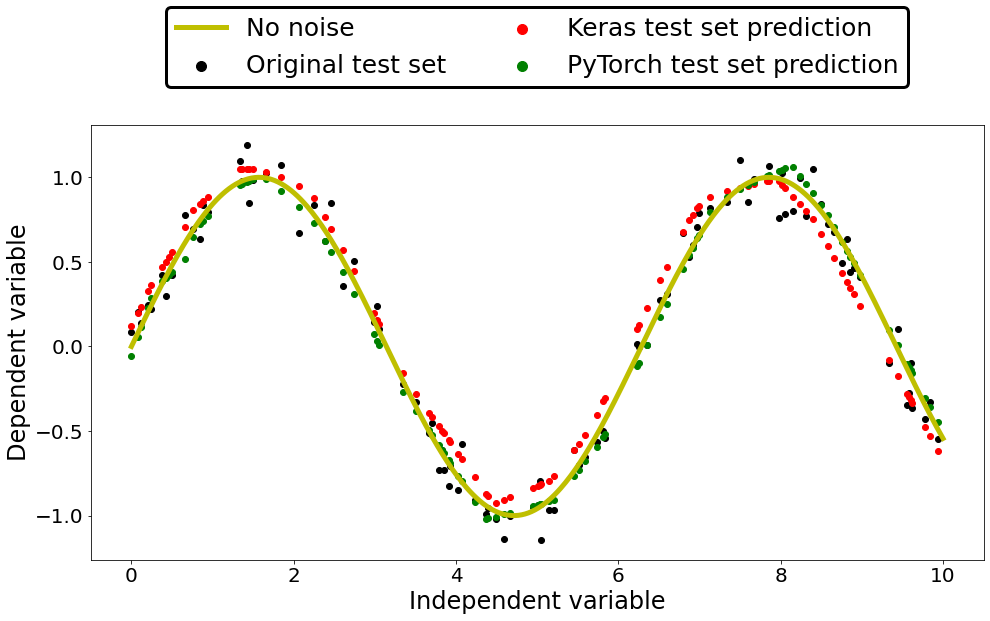

In [41]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_xlabel('Independent variable', fontsize=24)
ax.set_ylabel('Dependent variable', fontsize=24)

plt.plot(x, y, "y-", lw = 5, label = "No noise")
ax.scatter(X_test, y_test, color = "k", label = "Original test set")
ax.scatter(xK_test, model_K.predict(xK_test), color = "r", label = "Keras test set prediction")


prediction = model_PT(xPT_test)

ax.scatter(xPT_test.data.numpy(), prediction.data.numpy(), color='green', label = "PyTorch test set prediction")

legendObject = ax.legend(loc = 'upper center', bbox_to_anchor=(0.5, 1.3),
          ncol = 2, fontsize = 25, fancybox = True, shadow = False,
          facecolor = "w", framealpha = 1)
legendObject.get_frame().set_linewidth(3.0)
legendObject.get_frame().set_edgecolor("k")



for i in range(len(legendObject.legendHandles)):
    legendObject.legendHandles[i]._sizes = [100]  

plt.show()
fig.savefig("./img/result.png", bbox_inches='tight')

# Conclusions
<hr style="border:2px solid black"> </hr>


- Keras and PyTorch are two common deep leanring frameworks.
- We have seen how to build a simple MLP using these two focusing on finding a common template to abstract away the syntax differences.
- This allows us to build a routine to check how good are ANNs at approximating any function.



# References
<hr style="border:2px solid black"> </hr>


- https://medium.com/@benjamin.phillips22/simple-regression-with-neural-networks-in-pytorch-313f06910379
- [nn.Sequential vs. nn.Module in PyTorch](https://discuss.pytorch.org/t/differences-between-writing-models-with-nn-sequential-vs-creating-a-class/17470)
- [Different ways to build a sequential model in PyTorch](https://stackoverflow.com/questions/46141690/how-to-write-a-pytorch-sequential-model)
- [Early stopping on val or test set?](https://stats.stackexchange.com/questions/56421/is-it-ok-to-determine-early-stopping-using-the-validation-set-in-10-fold-cross-v)
- [Early stopping in PyTorch #1](https://medium.com/analytics-vidhya/early-stopping-with-pytorch-to-restrain-your-model-from-overfitting-dce6de4081c5)
- [Early stopping in PyTorch #2](https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb)
- [`num_workers` on `DataLoader`](https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813/10)
- [From MLP Keras to MLP PyTorch](https://stackoverflow.com/questions/66024261/how-can-i-convert-keras-mlp-model-to-pythorch-model)
- [How to print Keras's like summary in PyTorch](https://stackoverflow.com/questions/42480111/model-summary-in-pytorch)
- [What does `None` means in the Keras vector?](https://keras.io/api/layers/reshaping_layers/repeat_vector/)
   
